In [1]:
import tensorflow as tf
import math
import re

/Users/jbrandt.terminal/opt/anaconda3/envs/tf15/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/jbrandt.terminal/opt/anaconda3/envs/tf15/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/jbrandt.terminal/opt/anaconda3/envs/tf15/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/

In [2]:
sess = tf.Session()
from keras import backend as K
K.set_session(sess)

from time import sleep

import keras
from tensorflow.python.keras.layers import *
from tensorflow.python.keras.layers import ELU
from keras.losses import binary_crossentropy
from tensorflow.python.ops import array_ops
from tensorflow.python.keras.layers import Conv2D, Lambda, Dense, Multiply, Add
from tensorflow.initializers import glorot_normal, lecun_normal

import numpy as np
from random import shuffle

import os
import random
import itertools
from tensorflow.contrib.framework import arg_scope
from keras.regularizers import l1
from tensorflow.layers import batch_normalization
from tensorflow.python.util import deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

2023-12-22 11:51:04.652877: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-22 11:51:04.653801: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.
Using TensorFlow backend.


In [3]:
%run ../../src/layers/zoneout.py
%run ../../src/layers/adabound.py
%run ../../src/layers/adabelief.py

%run ../../src/layers/convgru.py
%run ../../src/layers/dropblock.py
%run ../../src/layers/extra_layers.py

In [4]:

def cse_block(prevlayer, prefix):
    '''Channel excitation and spatial squeeze layer. 
       Calculates the mean of the spatial dimensions and then learns
       two dense layers, one with relu, and one with sigmoid, to rerank the
       input channels
       
         Parameters:
          prevlayer (tf.Variable): input layer
          prefix (str): prefix for tensorflow scope

         Returns:
          x (tf.Variable): output of the cse_block
    '''
    mean = Lambda(lambda xin: K.mean(xin, axis=[1, 2]))(prevlayer)
    lin1 = Dense(K.int_shape(prevlayer)[3] // 2, name=prefix + 'cse_lin1', activation='relu')(mean)
    lin2 = Dense(K.int_shape(prevlayer)[3], name=prefix + 'cse_lin2', activation='sigmoid')(lin1)
    x = Multiply()([prevlayer, lin2])
    return x


def sse_block(prevlayer, prefix):
    '''Spatial excitation and channel squeeze layer.
       Calculates a 1x1 convolution with sigmoid activation to create a 
       spatial map that is multiplied by the input layer

         Parameters:
          prevlayer (tf.Variable): input layer
          prefix (str): prefix for tensorflow scope

         Returns:
          x (tf.Variable): output of the sse_block
    '''
    conv = Conv2D(1, (1, 1), padding="same", kernel_initializer=tf.keras.initializers.he_normal(),
                  activation='sigmoid', strides=(1, 1),
                  name=prefix + "_conv")(prevlayer)
    conv = Multiply(name=prefix + "_mul")([prevlayer, conv])
    return conv


def csse_block(x, prefix):
    '''Implementation of Concurrent Spatial and Channel 
       ‘Squeeze & Excitation’ in Fully Convolutional Networks
    
        Parameters:
          prevlayer (tf.Variable): input layer
          prefix (str): prefix for tensorflow scope

         Returns:
          x (tf.Variable): added output of cse and sse block
          
         References:
          https://arxiv.org/abs/1803.02579
    '''
    #cse = cse_block(x, prefix)
    sse = sse_block(x, prefix)
    #x = Add(name=prefix + "_csse_mul")([cse, sse])

    return sse

class ReflectionPadding2D(Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        self.input_spec = [InputSpec(ndim=4)]
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def compute_output_shape(self, s):
        """ If you are using "channels_last" configuration"""
        return (s[0], s[1] + 2 * self.padding[0], s[2] + 2 * self.padding[1], s[3])

    def call(self, x, mask=None):
        w_pad,h_pad = self.padding
        print("ZERO PADDING")
        return tf.pad(x, [[0,0], [h_pad,h_pad], [w_pad,w_pad], [0,0] ], 'REFLECT')
    
class ReflectionPadding5D(Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        self.input_spec = [InputSpec(ndim=4)]
        super(ReflectionPadding5D, self).__init__(**kwargs)

    def compute_output_shape(self, s):
        """ If you are using "channels_last" configuration"""
        return (s[0], s[1] + 2 * self.padding[0], s[2] + 2 * self.padding[1], s[3])

    def call(self, x, mask=None):
        w_pad,h_pad = self.padding
        print("ZERO PADDING")
        return tf.pad(x, [[0,0], [0, 0], [h_pad,h_pad], [w_pad,w_pad], [0,0] ], 'REFLECT')

In [5]:
kernel = np.array([[[[[1,-1], [-1, 1]]]]])
kernel.shape

(1, 1, 1, 2, 2)

In [6]:
def gru_block(inp, length, size, flt, scope, train, normalize = True):
    '''Bidirectional convolutional GRU block with 
       zoneout and CSSE blocks in each time step

         Parameters:
          inp (tf.Variable): (B, T, H, W, C) layer
          length (tf.Variable): (B, T) layer denoting number of
                                steps per sample
          size (int): kernel size of convolution
          flt (int): number of convolution filters
          scope (str): tensorflow variable scope
          train (tf.Bool): flag to differentiate between train/test ops
          normalize (bool): whether to compute layer normalization

         Returns:
          gru (tf.Variable): (B, H, W, flt*2) bi-gru output
          steps (tf.Variable): (B, T, H, W, flt*2) output of each step
    '''
    with tf.variable_scope(scope):
        print(f"GRU input shape {inp.shape}, zoneout: {0.1}")
        """
        cell_fw = ConvLSTMCell(shape = size, filters = flt,
                               kernel = [3, 3], forget_bias=1.0, 
                               activation=tf.tanh, normalize=True, 
                               peephole=False, data_format='channels_last', reuse=None)
        cell_bw = ConvLSTMCell(shape = size, filters = flt,
                               kernel = [3, 3], forget_bias=1.0, 
                               activation=tf.tanh, normalize=True, 
                               peephole=False, data_format='channels_last', reuse=None)
        """
        cell_fw = ConvGRUCell(shape = size, filters = flt,
                           kernel = [3, 3], padding = 'VALID', normalize = normalize, sse = True)
        cell_bw = ConvGRUCell(shape = size, filters = flt,
                           kernel = [3, 3], padding = 'VALID', normalize = normalize, sse = True)
        zoneout = 0.75
        cell_fw = ZoneoutWrapper(
           cell_fw, zoneout_drop_prob = zoneout, is_training = train)
        cell_bw = ZoneoutWrapper(
            cell_bw, zoneout_drop_prob = zoneout, is_training = train)
        print(inp.shape)
        steps, out = convGRU(inp, cell_fw, cell_bw, length)
        print(f"Zoneout: {zoneout}")
        gru = tf.concat(out, axis = -1)
        steps = tf.concat(steps, axis = -1)
        print(f"Down block output shape {gru.shape}")
    return gru, steps


def attention(inp, units):
    weighted = TimeDistributed(Conv2D(units, (1, 1), padding = 'same', kernel_initializer = tf.keras.initializers.Ones(),
                            activation = 'sigmoid', strides = (1, 1), use_bias = False, ))(inp) 
    alphas = tf.reduce_sum(weighted, axis = 1, keep_dims = True)
    alphas = weighted / alphas
    multiplied = tf.reduce_sum(alphas * inp, axis = 1)
    print(multiplied.shape)
    return multiplied

In [7]:



class WSConv2D(tf.keras.layers.Conv2D):
    def __init__(self, filters,
                 kernel_size,
                 strides=(1, 1),
                 padding='valid',
                 data_format=None,
                 dilation_rate=(1, 1),
                 activation=None,
                 use_bias=False,
                 kernel_initializer='he_normal',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 **kwargs):
        super(WSConv2D, self).__init__(filters=filters,
                 kernel_size=kernel_size,
                 strides=strides,
                 padding=padding,
                 data_format=data_format,
                 dilation_rate=dilation_rate,
                 activation=activation,
                 use_bias=use_bias,
                 kernel_initializer=kernel_initializer,
                 bias_initializer=bias_initializer,
                 kernel_regularizer=kernel_regularizer,
                 bias_regularizer=bias_regularizer,
                 activity_regularizer=activity_regularizer,
                 kernel_constraint=kernel_constraint,
                 bias_constraint=bias_constraint,
                 **kwargs)
        
    def standardize_weight(self, weight, eps):

        mean = tf.math.reduce_mean(weight, axis=(0, 1, 2), keepdims=True)
        weight = weight - mean
        var = K.sqrt(K.var(weight, axis=[0,1,2], keepdims=True) + 1e-8)
        weight = weight / (var + 1e-5)
        return weight

    def call(self, inputs):
       # weight = self.standardize_weight(self.kernel, 1e-5)

        outputs = K.conv2d(
            inputs,
            self.kernel,
            strides=self.strides,
            padding=self.padding,
            data_format=self.data_format,
            dilation_rate=self.dilation_rate)
        
        if self.use_bias:
            outputs = K.bias_add(
                outputs,
                self.bias,
                data_format=self.data_format)

        if self.activation is not None:
            return self.activation(outputs)
        return outputs


class WSConv2D(tf.keras.layers.Conv2D):
    def __init__(self, *args, **kwargs):
        super(WSConv2D, self).__init__(kernel_initializer="he_normal", *args, **kwargs)

    def standardize_weight(self, weight, eps):

        mean = tf.math.reduce_mean(weight, axis=(0, 1, 2), keepdims=True)
        weight = weight - mean
        var = tf.keras.backend.std(weight, axis=[0, 1, 2], keepdims=True)
        weight = weight / (var + 1e-5)
        return weight

    def call(self, inputs, eps=1e-4):
        self.kernel.assign(self.kernel, eps)
        return super().call(inputs)

def partial_conv(x, channels, kernel=3, stride=1, norm = True, use_bias=False, padding='SAME', scope='conv_0'):
    

    
    with tf.variable_scope(scope):
        if padding.lower() == 'SAME'.lower() :
            with tf.variable_scope('mask'):
                _, h, w, _ = x.get_shape().as_list()

                slide_window = kernel * kernel
                mask = tf.ones(shape=[1, h, w, 1])

                update_mask = tf.layers.conv2d(mask, filters=1,
                                               kernel_size=kernel, kernel_initializer=tf.constant_initializer(1.0),
                                               strides=stride, padding=padding, use_bias=False, trainable=False)

                mask_ratio = slide_window / (update_mask + 1e-8)
                update_mask = tf.clip_by_value(update_mask, 0.0, 1.0)
                mask_ratio = mask_ratio * update_mask

            with tf.variable_scope('x'):
                if 4 > 3:
                    x = WSConv2D(filters=channels, kernel_regularizer = None,
                                     kernel_size=kernel,
                                     strides=stride, padding=padding, use_bias=False).apply(x)
                else:
                    x = tf.layers.conv2d(x, filters=channels, kernel_regularizer = None,
                                     kernel_size=kernel, kernel_initializer=tf.keras.initializers.he_normal(),
                                     strides=stride, padding=padding, use_bias=False)
    
                x = x * mask_ratio
                
                

                if use_bias:
                    bias = tf.get_variable("bias", [channels], initializer=tf.constant_initializer(0.0))

                    x = tf.nn.bias_add(x, bias)
                    x = x * update_mask

        else :
            if 4 > 3:
                x = WSConv2D(filters=channels,kernel_regularizer = None,
                                 kernel_size=kernel,
                                 strides=stride, padding=padding, use_bias=False).apply(x)
            else:
                x = tf.layers.conv2d(x, filters=channels,kernel_regularizer = None,
                                 kernel_size=kernel, kernel_initializer=tf.keras.initializers.he_normal(),
                                 strides=stride, padding=padding, use_bias=use_bias)

        return x
    

def conv_swish_gn(inp, 
                 is_training, 
                 kernel_size,
                 scope,
                 filters, 
                 keep_rate,
                 stride = (1, 1),
                 activation = True,
                 use_bias = False,
                 norm = True,
                 dropblock = True,
                 csse = True,
                 weight_decay = None,
                 block_size = 5,
                 padding = "SAME",
                 window_size = 48):
    '''2D convolution, batch renorm, relu block, 3x3 drop block. 
       Use_bias must be set to False for batch normalization to work. 
       He normal initialization is used with batch normalization.
       RELU is better applied after the batch norm.
       DropBlock performs best when applied last, according to original paper.

         Parameters:
          inp (tf.Variable): input layer
          is_training (str): flag to differentiate between train/test ops
          kernel_size (int): size of convolution
          scope (str): tensorflow variable scope
          filters (int): number of filters for convolution
          clipping_params (dict): specifies clipping of 
                                  rmax, dmax, rmin for renormalization
          activation (bool): whether to apply RELU
          use_bias (str): whether to use bias. Should always be false

         Returns:
          bn (tf.Variable): output of Conv2D -> Batch Norm -> RELU
        
         References:
          http://papers.nips.cc/paper/8271-dropblock-a-regularization-
              method-for-convolutional-networks.pdf
          https://arxiv.org/abs/1702.03275
          
    '''
    
    bn_flag = "Group Norm" if norm else ""
    activation_flag = "RELU" if activation else "Linear"
    csse_flag = "CSSE" if csse else "No CSSE"
    bias_flag = "Bias" if use_bias else "NoBias"
    drop_flag = "DropBlock" if dropblock else "NoDrop"
        
    
    print("{} {} Conv 2D {} {} {} {} {}".format(scope, kernel_size,
                                                   bn_flag, activation_flag,
                                                   csse_flag, bias_flag, drop_flag))
    
    with tf.variable_scope(scope + "_conv"):
        #conv = Conv2D(filters = filters, kernel_size = (kernel_size, kernel_size),  strides = stride,
        #              activation = None, padding = 'valid', use_bias = use_bias,
                      #kernel_regularizer = weight_decay,
        #              kernel_initializer = tf.keras.initializers.he_normal())(inp)
        conv = partial_conv(inp, filters, kernel=kernel_size, stride=1, 
                            use_bias=False, padding=padding, scope = scope)
    print(f"The non normalized feats are {conv}")    
    if activation:
        conv = tf.nn.swish(conv)
    print(f"The non normalized feats are {conv}")
    # if dropblock:
    #.    mask = make_mask()
    
    if norm:
        conv = group_norm(x = conv, scope = scope, G = 8,#(filters // 4), 
                          window_size = window_size) #mask = mask
    if csse:
        conv = csse_block(conv, "csse_" + scope)
    
    if dropblock: 
        with tf.variable_scope(scope + "_drop"):
            drop_block = DropBlock2D(keep_prob=keep_rate, block_size= block_size)
            conv = drop_block(conv, is_training)
    return conv

In [8]:
INPUT_SIZE = 124#220 
SIZE_X = 124 # 684

n_bands = 17   
inp = tf.placeholder(tf.float32, shape=(1, 5, INPUT_SIZE, SIZE_X, n_bands))
length = tf.placeholder_with_default(np.full((1,), 4), shape = (None,))
labels = tf.placeholder(tf.float32, shape=(None, INPUT_SIZE - 14, INPUT_SIZE - 14))#, 1))
keep_rate = tf.placeholder_with_default(1.0, ()) # For DropBlock
is_training = tf.placeholder_with_default(False, (), 'is_training') # For BN, DropBlock
alpha = tf.placeholder(tf.float32, shape = ()) # For loss scheduling
ft_lr = tf.placeholder_with_default(0.001, shape = ()) # For loss scheduling
loss_weight = tf.placeholder_with_default(1.0, shape = ())
beta_ = tf.placeholder_with_default(0.0, shape = ())

In [9]:
# master modmel is 32, 64, 96, 230k paramms
initial_flt = 64
mid_flt = initial_flt * 2
high_flt = initial_flt * 2 * 2

gru_input = inp[:, :-1, ...]
gru, steps = gru_block(inp = gru_input, length = length,
                            size = [INPUT_SIZE, SIZE_X, ], # + 2 here for refleclt pad
                            flt = initial_flt // 2,
                            scope = 'down_16',
                            train = is_training)
with tf.variable_scope("gru_drop"):
    drop_block = DropBlock2D(keep_prob=keep_rate, block_size=4)
    gru = drop_block(gru, is_training)
    
# Median conv
median_input = inp[:, -1, ...]
median_conv = conv_swish_gn(inp = median_input, is_training = is_training, stride = (1, 1),
            kernel_size = 3, scope = 'conv_median', filters = initial_flt, 
            keep_rate = keep_rate, activation = True, use_bias = False, norm = True,
            csse = True, dropblock = True, weight_decay = None,
                            window_size = 104)
print(f"Median conv: {median_conv.shape}")

concat1 = tf.concat([gru, median_conv], axis = -1)


concat = conv_swish_gn(inp = concat1, is_training = is_training, stride = (1, 1),
            kernel_size = 3, scope = 'conv_concat', filters = initial_flt,
            keep_rate = keep_rate, activation = True, use_bias = False, norm = True,
            csse = True, dropblock = True, weight_decay = None, padding = "SAME",
                       window_size = 104)
print(f"Concat: {concat.shape}")

# MaxPool-conv-swish-GroupNorm-csse
pool1 = MaxPool2D()(concat)
conv1 = conv_swish_gn(inp = pool1, is_training = is_training, stride = (1, 1),
            kernel_size = 3, scope = 'conv1', filters = mid_flt,
            keep_rate = keep_rate, activation = True, use_bias = False, norm = True, padding = "VALID",
            csse = True, dropblock = True, weight_decay = None)
print(f"Conv1: {conv1.shape}")

# MaxPool-conv-swish-csse-DropBlock
pool2 = MaxPool2D()(conv1)
conv2 = conv_swish_gn(inp = pool2, is_training = is_training, stride = (1, 1),
            kernel_size = 3, scope = 'conv2', filters = high_flt, 
            keep_rate = keep_rate, activation = True, use_bias = False, norm = True,
            csse = True, dropblock = True, weight_decay = None, block_size = 4, padding = "VALID",
                     window_size = 24)
print("Encoded", conv2.shape)

# Decoder 4 - 8, upsample-conv-swish-csse-concat-conv-swish
up2 = tf.keras.layers.UpSampling2D((2, 2), interpolation = 'nearest')(conv2)
#up2 = ReflectionPadding2D((1, 1,))(up2)
up2 = conv_swish_gn(inp = up2, is_training = is_training, stride = (1, 1),
                    kernel_size = 3, scope = 'up2', filters = mid_flt, 
                    keep_rate = keep_rate, activation = True,use_bias = False, norm = True,
                    csse = True, dropblock = True, weight_decay = None)
conv1_crop = Cropping2D(2)(conv1)
print(conv1_crop.shape)
up2 = tf.concat([up2, conv1_crop], -1)
#up2 = ReflectionPadding2D((1, 1,))(up2)
up2 = conv_swish_gn(inp = up2, is_training = is_training, stride = (1, 1),
                    kernel_size = 3, scope = 'up2_out', filters = mid_flt, 
                    keep_rate =  keep_rate, activation = True,use_bias = False, norm = True,
                    csse = True, dropblock = True, weight_decay = None)

# Decoder 8 - 14 upsample-conv-swish-csse-concat-conv-swish
up3 = tf.keras.layers.UpSampling2D((2, 2), interpolation = 'nearest')(up2)
#up3 = ReflectionPadding2D((1, 1,))(up3)
up3 = conv_swish_gn(inp = up3, is_training = is_training, stride = (1, 1),
                    kernel_size = 3, scope = 'up3', filters = initial_flt, 
                    keep_rate = keep_rate, activation = True, use_bias = False, norm = True,
                    csse = True, dropblock = True, weight_decay = None, 
                    window_size = 104)
gru_crop = Cropping2D(6)(concat)
print(up3.shape)
print(gru_crop.shape)
up3 = tf.concat([up3, gru_crop], -1)

up3out = conv_swish_gn(inp = up3, is_training = is_training, stride = (1, 1),
                    kernel_size = 3, scope = 'out', filters = initial_flt, 
                    keep_rate  = keep_rate, activation = True,use_bias = False, norm = True,
                    csse = True, dropblock = False, weight_decay = None, padding = "VALID",
                       window_size = 104)

init = tf.constant_initializer([-np.log(0.7/0.3)]) # For focal loss
print(f"The output is {up2.shape}, with a receptive field of {1}")
fm = tf.layers.Conv2D(filters = 1,
            kernel_size = (1, 1),
            padding = 'valid',
            activation = 'sigmoid',
            bias_initializer = init, name = 'conv2d')(up3out)#,
print(fm)


GRU input shape (1, 4, 124, 124, 17), zoneout: 0.1
(1, 4, 124, 124, 17)

(3, 3, 49, 64)
(3, 3, 49, 64)
Zoneout: 0.75
Down block output shape (1, 124, 124, 64)

conv_median 3 Conv 2D Group Norm RELU CSSE NoBias DropBlock
The non normalized feats are Tensor("conv_median_conv/conv_median/x/mul:0", shape=(1, 124, 124, 64), dtype=float32)
The non normalized feats are Tensor("swish_f32:0", shape=(1, 124, 124, 64), dtype=float32)

Median conv: (1, 124, 124, 64)
conv_concat 3 Conv 2D Group Norm RELU CSSE NoBias DropBlock
The non normalized feats are Tensor("conv_concat_conv/conv_concat/x/mul:0", shape=(1, 124, 124, 64), dtype=float32)
The non normalized feats are Tensor("swish_f32_1:0", shape=(1, 124, 124, 64), dtype=float32)
Concat: (1, 124, 124, 64)
conv1 3 Conv 2D Group Norm RELU CSSE NoBias DropBlock
The non normalized feats are Tensor("conv1_conv/conv1/ws_conv2d_2/Conv2D:0", shape=(1, 60, 60, 128), dtype=float32)
The non normalized feats are Tensor("swish_f32_2:0", shape=(1, 60, 60, 128)

'\nprint(f"The output, sigmoid is {fm.shape}, with a receptive field of {1}")\n\n\n\nup4 = conv_swish_gn(inp = up3, is_training = is_training, stride = (1, 1),\n                    kernel_size = 3, scope = \'outregressor\', filters = 64, \n                    keep_rate  = keep_rate, activation = True, use_bias = False, norm = True,\n                    csse = True, dropblock = True, weight_decay = None, padding = "SAME")\n\nup5 = conv_swish_gn(inp = up4, is_training = is_training, stride = (1, 1),\n                    kernel_size = 3, scope = \'outregressor2\', filters = 64, \n                    keep_rate  = keep_rate, activation = True, use_bias = False, norm = True,\n                    csse = True, dropblock = False, weight_decay = None, padding = "VALID")\n\nregression = Conv2D(filters = 1,\n            kernel_size = (1, 1),\n            padding = \'valid\',\n            activation = \'linear\',\n            #bias_initializer = init,\n           )(up5)\nregression = Cropping2D(1)(

In [12]:
from keras.losses import binary_crossentropy
import math
from scipy.ndimage import distance_transform_edt as distance

def calc_mask(seg):

    res = np.zeros_like(seg)
    posmask = seg.astype(np.bool)
    loss_importance = np.array([x for x in range(0, 197, 1)])
    loss_importance = loss_importance / 196
    loss_importance = np.expm1(loss_importance)
    loss_importance[:30] = 0.

    if posmask.any():
        negmask = ~posmask
        res = distance(negmask) * negmask - (distance(posmask) - 1) * posmask
    if np.sum(seg) == 196:
        res = np.ones_like(seg)
    if np.sum(seg) == 0:
        res = np.ones_like(seg)
    res[np.logical_and(res < 2, res > 0)] = 0.5
    res[np.logical_or(res >= 2, res <= 0)] = 1.
    return res

def calc_mask_batch(y_true):
    '''Applies calc_dist_map to each sample in an input batch
    
         Parameters:
          y_true (arr):
          
         Returns:
          loss (arr):
    '''
    y_true_numpy = y_true.numpy()
    bce_batch = np.array([calc_mask(y)
                     for y in y_true_numpy]).astype(np.float32)
    return bce_batch

def weighted_bce_loss(y_true, y_pred, weight, mask = True, smooth = 0.03):
    '''Calculates the weighted binary cross entropy loss between y_true and
       y_pred with optional masking and smoothing for regularization
       
       For smoothing, we want to weight false positives as less important than
       false negatives, so we smooth false negatives 2x as much. 
    
         Parameters:
          y_true (arr):
          y_pred (arr):
          weight (float):
          mask (arr):
          smooth (float):

         Returns:
          loss (float):
    '''
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    y_true = K.clip(y_true, smooth, 1. - smooth)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    loss = tf.nn.weighted_cross_entropy_with_logits(
        y_true,
        logit_y_pred,
        weight,
    )

    return loss

def calc_dist_map(seg):
    #Utility function for calc_dist_map_batch that calculates the loss
    #   importance per pixel based on the surface distance function
    
     #    Parameters:
    #      seg (arr):
     #     
    #     Returns:
    #      res (arr):
    #
    res = np.zeros_like(seg)
    posmask = seg.astype(np.bool)

    mults = np.ones_like(seg)
    ones = np.ones_like(seg)
    for x in range(1, res.shape[0] -1 ):
        for y in range(1, res.shape[0] - 1):
            if seg[x, y] == 1:
                l = seg[x - 1, y]
                r = seg[x + 1, y]
                u = seg[x, y + 1]
                d = seg[x, y - 1]
                lu = seg[x - 1, y + 1]
                ru = seg[x + 1, y + 1]
                rd = seg[x + 1, y - 1]
                ld = seg[x -1, y - 1]
                
                sums = (l + r + u + d)
                sums2 = (l + r + u + d + lu + ru +rd + ld)
                if sums >= 2:
                    mults[x, y] = 2
                if sums2 <= 1:
                    ones[x - 1, y] = 0.5
                    ones[x + 1, y] = 0.5
                    ones[x, y + 1] = 0.5
                    ones[x, y - 1] = 0.5
                    ones[x - 1, y + 1] = 0.5
                    ones[x + 1, y + 1] = 0.5
                    ones[x + 1, y - 1] = 0.5
                    ones[x -1, y - 1] = 0.5

    if posmask.any():
        
        negmask = ~posmask
        res = distance(negmask) * negmask - (distance(posmask) - 1) * posmask
        # When % = 1, 0 -> 1.75
        # When % = 100, 0 -> 0
        res = np.round(res, 0)
        res[np.where(np.isclose(res, -.41421356, rtol = 1e-2))] = -1
        res[np.where(res == -1)] = -1 * mults[np.where(res == -1)]
        res[np.where(res == 0)] = -1  * mults[np.where(res == 0)]
        # When % = 1, 1 -> 0
        # When % = 100, 1 -> 1.75
        res[np.where(res == 1)] = 1 * ones[np.where(res == 1)]
        res[np.where(res == 1)] *= 0.67
        #res[np.where(np.isclose(res, 1.41421356, rtol = 1e-2))] = loss_importance[sums]
        
    res[np.where(res < -3)] = -3
    res[np.where(res > 3)] = 3
    if np.sum(seg) == 196:
        res = np.ones_like(seg)
        res *= -1
    if np.sum(seg) == 0:
        res = np.ones_like(seg)
    return res


def calc_dist_map_batch(y_true):
    '''Applies calc_dist_map to each sample in an input batch
    
         Parameters:
          y_true (arr):
          
         Returns:
          loss (arr):
    '''
    y_true_numpy = y_true.numpy()
    return np.array([calc_dist_map(y)
                     for y in y_true_numpy]).astype(np.float32)

def surface_loss(y_true, y_pred):
    '''Calculates the mean surface loss for the input batch
       by multiplying the distance map by y_pred
    
         Parameters:
          y_true (arr):
          y_pred (arr):
          
         Returns:
          loss (arr):
        
         References:
          https://arxiv.org/abs/1812.07032
    '''
    y_true_dist_map = tf.py_function(func=calc_dist_map_batch,
                                     inp=[y_true],
                                     Tout=tf.float32)
    y_true_dist_map = tf.stack(y_true_dist_map, axis = 0)
    multipled = y_pred * y_true_dist_map
    loss = tf.reduce_mean(multipled, axis = (1, 2, 3))
    return loss

def tf_percentile(x, p):
    with tf.name_scope('percentile'):
        y = tf.transpose(x)  # take percentile over batch dimension
        sorted_y = tf.sort(y)
        frac_idx = tf.cast(p, tf.float64) / 100. * (tf.cast(tf.shape(y)[-1], tf.float64) - 1.)
        return 0.5 * (  # using midpoint rule
            tf.gather(sorted_y, tf.cast(tf.math.ceil(frac_idx), tf.int32), axis=-1)
            + tf.gather(sorted_y, tf.cast(tf.math.floor(frac_idx), tf.int32), axis=-1))

def lovasz_surf(y_true, y_pred, alpha, weight, beta):
    
    #lv = lovasz_softmax(probas = y_pred,
    #                    labels = tf.reshape(y_true, (-1, 14, 14)), 
    #                    classes=[1],
    #                    per_image=False) 
    
    bce = weighted_bce_loss(y_true = y_true, 
                             y_pred = y_pred, 
                             weight = weight,
                             smooth = 0.05)


    bce = tf.reduce_mean(bce, axis = (1, 2, 3))
    surface = surface_loss(tf.cast(tf.math.greater(y_true, 0.10), tf.float32), y_pred)
    surface = tf.reshape(surface, tf.shape(bce))
    print(surface.shape)

    bce = (1 - alpha) * bce
    surface_portion = alpha * surface
    
    #result = bce + lovasz
    result = bce + surface_portion
    upper_bound = tf_percentile(result, 90)
    result = tf.clip_by_value(result, tf.reduce_min(result), upper_bound)
    result = tf.reduce_mean(result)
    return result



In [13]:
def weighted_bce_loss(y_true, y_pred, weight, mask = True, smooth = 0.05):
    '''Calculates the weighted binary cross entropy loss between y_true and
       y_pred with optional masking and smoothing for regularization
       
       For smoothing, we want to weight false positives as less important than
       false negatives, so we smooth false negatives 2x as much. 
    
         Parameters:
          y_true (arr):
          y_pred (arr):
          weight (float):
          mask (arr):
          smooth (float):

         Returns:
          loss (float):
    '''
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    y_true = K.clip(y_true, smooth / 5, 1. - smooth)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    
    paddings = paddings = tf.constant([[0, 0], [1, 1], [1, 1], [0, 0]])
    logit_y_pred_positive = tf.pad(
        logit_y_pred, paddings, mode='CONSTANT', name=None, constant_values=0,
    )
    logit_y_pred_maximum = MaxPool2D(pool_size=(3, 3), strides=(1, 1), padding='valid')(logit_y_pred_positive)
    loss_negative = tf.nn.weighted_cross_entropy_with_logits(
        y_true,
        logit_y_pred,
        weight,
    )
    
    loss_positive = loss_negative = tf.nn.weighted_cross_entropy_with_logits(
        y_true,
        logit_y_pred_maximum,
        weight,
    )
    
    where_positive = tf.cast(tf.math.greater(y_true, 0.5), tf.float32)
    where_negative = 1 - where_positive
    loss_positive = loss_positive * where_positive
    loss_negative = loss_negative * where_negative
                                                     

    return (loss_positive + loss_negative)

In [14]:

%run ../../src/layers/adabound.py
def grad_norm(gradients):
        norm = tf.norm(
            tf.stack([
                tf.norm(grad) for grad in gradients if grad is not None
            ])
        )
        return norm
    

optimizer = AdaBoundOptimizer(1e-3, 0.1)
train_loss = lovasz_surf(tf.reshape(labels, (-1, INPUT_SIZE - 14, SIZE_X - 14, 1)), 
                         fm, weight = loss_weight, 
                         alpha = alpha, beta = beta_)
#train_loss2 = lovasz_surf(tf.reshape(labels, (-1, INPUT_SIZE - 14, SIZE_X - 14, 1)), 
#                         regression, weight = loss_weight, 
#                         alpha = alpha, beta = beta_)
train_loss = train_loss# + train_loss2
#l2_loss = tf.losses.get_regularization_loss()
#if len(tf.losses.get_regularization_losses()) > 0:
#    print("Adding L2 loss")
#    train_loss = train_loss + l2_loss

test_loss = lovasz_surf(tf.reshape(labels, (-1, INPUT_SIZE - 14, SIZE_X - 14, 1)),
                        fm, weight = loss_weight, 
                        alpha = alpha, beta = beta_)
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.control_dependencies(update_ops):
    train_op = optimizer.minimize(train_loss)   
"""
trainable_params = tf.trainable_variables()
gradients = optimizer.compute_gradients(loss=train_loss, var_list=None)
gradient_norm = grad_norm(gradients)
scale = 0.05 / (gradient_norm + 1e-12)
e_ws = []
for (grad, param) in gradients:
    e_w = grad * scale
    param.assign_add(e_w)
    e_ws.append(e_w)

sam_gradients = optimizer.compute_gradients(loss=train_loss, var_list=None)
for (param, e_w) in zip(trainable_params, e_ws):
    param.assign_sub(e_w)
train_step = optimizer.apply_gradients(sam_gradients)
"""

init_op = tf.global_variables_initializer()
sess.run(init_op)
saver = tf.train.Saver(max_to_keep = 150)

(?,)
(?,)


2023-12-22 11:51:08.335716: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [15]:

def get_tensors_in_checkpoint_file(file_name,all_tensors=True,tensor_name=None):
    varlist=[]
    var_value =[]
    reader = tf.compat.v1.train.NewCheckpointReader(file_name)
    if all_tensors:
        var_to_shape_map = reader.get_variable_to_shape_map()
        for key in sorted(var_to_shape_map):
            varlist.append(key)
            var_value.append(reader.get_tensor(key))
    else:
        varlist.append(tensor_name)
        var_value.append(reader.get_tensor(tensor_name))
    return (varlist, var_value)

def build_tensors_in_checkpoint_file(loaded_tensors):
    full_var_list = list()
    # Loop all loaded tensors
    for i, tensor_name in enumerate(loaded_tensors[0]):
        # Extract tensor
        try:
            tensor_aux = tf.get_default_graph().get_tensor_by_name(tensor_name+":0")
            full_var_list.append(tensor_aux)
        except:
            print('Not found: '+tensor_name)
        
    return full_var_list

checkpoint_dir = "../../models/tml-july-18-2-150-july28/"
all_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
all_vars = [x for x in all_vars if 'conv3d' not in x.name]
    
saver = tf.train.Saver(max_to_keep = 150, var_list = all_vars)
#restored_vars[0]
#tensors_to_load = build_tensors_in_checkpoint_file(restored_vars)
#saver.restore(sess, CHECKPOINT_NAME)



In [16]:
def make_saver_varlist(path):

    current_items = []
    vars_dict = {}
    for var_current in tf.global_variables():
        current_items.append(var_current) 
    names = [x.op.name for x in current_items]
    names = np.argsort(names)
    current_items = [current_items[x] for x in names]
    
    ckpt_items = []
    for var_ckpt in tf.train.list_variables(path):
        if 'BackupVariables' not in var_ckpt[0]:
            if 'StochasticWeightAveraging' not in var_ckpt[0]:
                if 'global_step' not in var_ckpt[0]:
                    if 'is_training' not in var_ckpt[0]:
                        if 'n_models' not in var_ckpt[0]:
                            ckpt_items.append(var_ckpt[0])
    
    ckptdict = {}
    for y, x in zip(ckpt_items, current_items):
        ckptdict[y] = x
    return ckptdict

In [17]:
i = 0
ckptdict = make_saver_varlist('../../models/172-ttc-dec2023-3/')
saver = tf.train.Saver(ckptdict)

In [18]:

path = '../../models/172-ttc-dec2023-3/'#2023-adabound6-reg2-retrain-master/'#fs[i]# "../../models/ft/"#adabound6-average/"#fs[i]#"../../models/aug16/"#fs[i]
saver.restore(sess, tf.train.latest_checkpoint(path))
output_node_names = ['conv2d/Sigmoid']    # Output nodes
#print(i + 1, "/", len(fs))
frozen_graph_def = tf.graph_util.convert_variables_to_constants(
    sess,
    sess.graph_def,
    output_node_names)
#retrain-combined-ca-220-684/
# Save the rozen graph 
#with open('../../models/172-ttc-dec2023-3/predict_graph-124.pb', 'wb') as f:
 #   f.write(frozen_graph_def.SerializeToString())
i += 1

INFO:tensorflow:Restoring parameters from ../../models/172-ttc-dec2023-3/-0
INFO:tensorflow:Froze 65 variables.
INFO:tensorflow:Converted 65 variables to const ops.


In [21]:
x_batch = np.load("../batch_x.npy")

In [28]:
out = sess.run([fm], #
              feed_dict={inp: x_batch[np.newaxis],
                         length: np.full((1,), 4),
                         #labels: y_batch,
                         #mask: mask_batch,
                         is_training: False,
                         loss_weight: 1.,
                         keep_rate: 1.,
                         alpha: 0.5,
                         beta_: 0.5,
                         ft_lr: 0.5,
                         })

<AxesSubplot:>

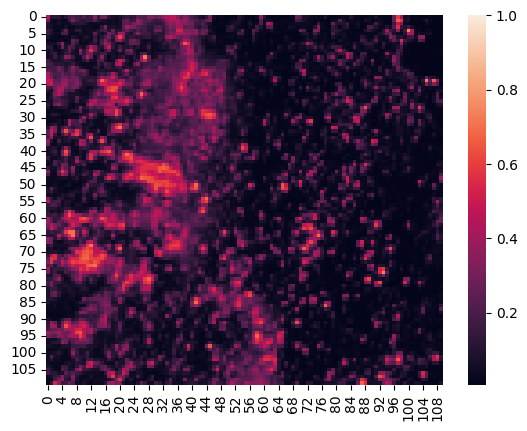

In [30]:
import seaborn as sns
sns.heatmap(out[0].squeeze(), vmax = 1.)